# Introducing Deep Learning for Time Series Forecasting

### When to use deep learning for time series forecasting?
Deep learning shines when we have large complex datasets. In those situations, deep
learning can leverage all the available data to infer relationships between each feature
and the target, usually resulting in good forecasts. *In the context of time series, a dataset is considered to be large when we have
more than* **10,000 data points***.*

# Preprocessing

In [4]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/refs/heads/master/data/metro_interstate_traffic_volume_preprocessed.csv')
df.head()

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume
0,2016-09-29 17:00:00,291.75,0.0,0,0,5551.0
1,2016-09-29 18:00:00,290.36,0.0,0,0,4132.0
2,2016-09-29 19:00:00,287.86,0.0,0,0,3435.0
3,2016-09-29 20:00:00,285.91,0.0,0,0,2765.0
4,2016-09-29 21:00:00,284.31,0.0,0,0,2443.0


In [6]:
df.tail()

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume
17546,2018-09-30 19:00:00,283.45,0.0,0,75,3543.0
17547,2018-09-30 20:00:00,282.76,0.0,0,90,2781.0
17548,2018-09-30 21:00:00,282.73,0.0,0,90,2159.0
17549,2018-09-30 22:00:00,282.09,0.0,0,90,1450.0
17550,2018-09-30 23:00:00,282.12,0.0,0,90,954.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17551 entries, 0 to 17550
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date_time       17551 non-null  object 
 1   temp            17551 non-null  float64
 2   rain_1h         17551 non-null  float64
 3   snow_1h         17551 non-null  int64  
 4   clouds_all      17551 non-null  int64  
 5   traffic_volume  17551 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 822.8+ KB


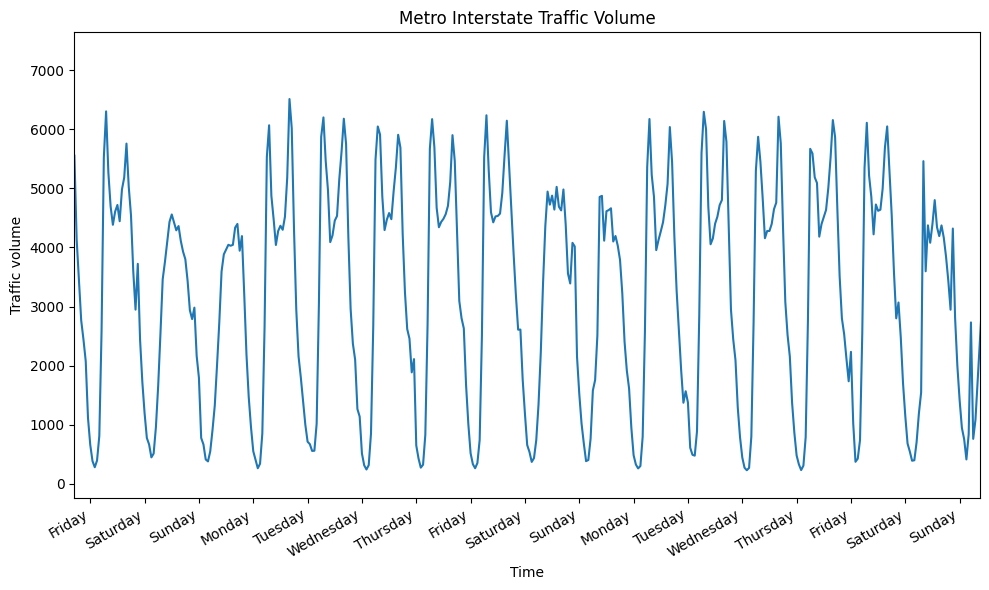

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df['traffic_volume'])
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')
ax.set_title("Metro Interstate Traffic Volume")
plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday',
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
    'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
    'Saturday', 'Sunday'])

plt.xlim(0, 400)
fig.autofmt_xdate()
plt.tight_layout()

*Westbound traffic volume on I-94 between Minneapolis and St. Paul in Minnesota, starting on
September 29, 2016, at 5 p.m. You’ll notice clear daily seasonality, with traffic being lower at the start and end
of each day.*

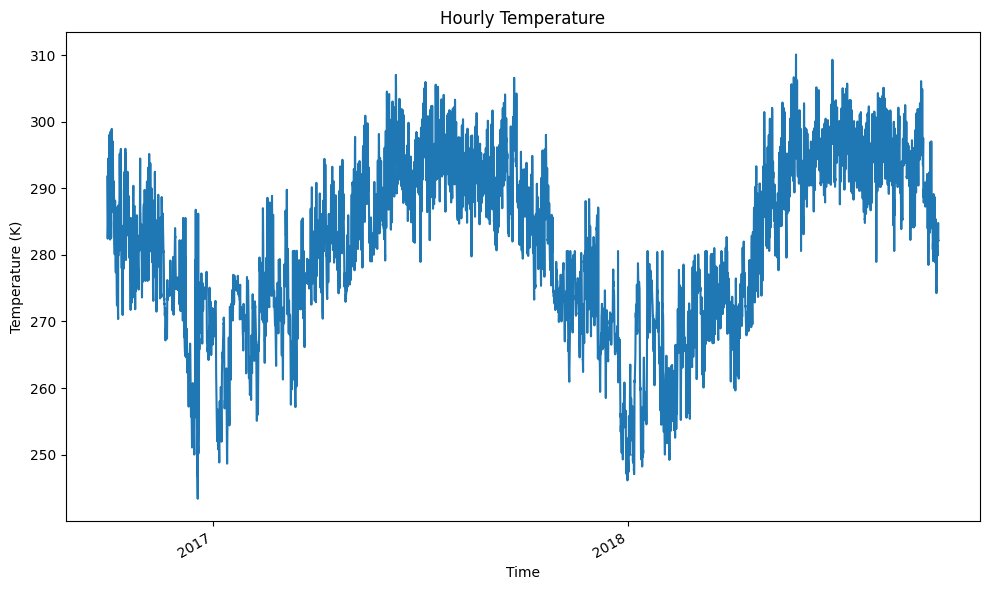

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df['temp'])
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')
ax.set_title("Hourly Temperature")
plt.xticks([2239, 10999], [2017, 2018])
fig.autofmt_xdate()
plt.tight_layout()

*Hourly temperature (in Kelvin) from September 29, 2016, to September 30, 2018. Although there is
noise, we can see a yearly seasonal pattern.*

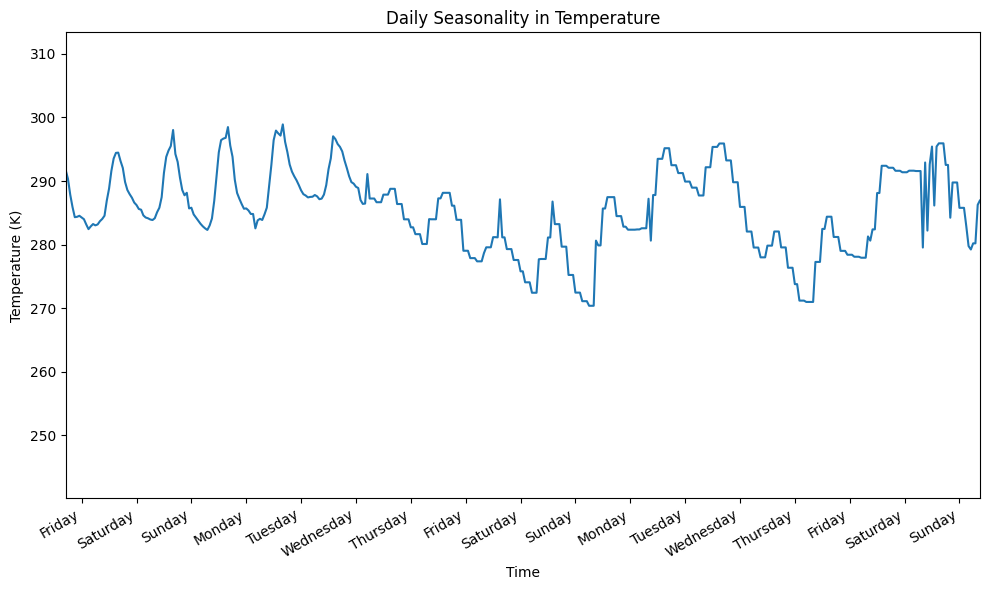

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df['temp'])
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')
ax.set_title("Daily Seasonality in Temperature")

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday',
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
    'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
    'Saturday', 'Sunday'])

plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

*Hourly temperature (in Kelvin) starting on September 29, 2016, at 5 p.m. CST. Although it is a bit
noisy, we can see that temperatures are indeed lower at the start and end of each day and peak during midday,
suggesting daily seasonality.*

In [14]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,17551.000000,17551.000000,17551.0,17551.000000,17551.000000
mean,281.416203,0.025523,0.0,42.034129,3321.484588
std,12.688262,0.259794,0.0,39.065960,1969.223949
min,243.390000,0.000000,0.0,0.000000,113.000000
25%,272.220000,0.000000,0.0,1.000000,1298.000000
50%,282.410000,0.000000,0.0,40.000000,3518.000000
75%,291.890000,0.000000,0.0,90.000000,4943.000000
max,310.070000,10.600000,0.0,100.000000,7280.000000


In [15]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,17551.0,281.416203,12.688262,243.39,272.22,282.41,291.89,310.07
rain_1h,17551.0,0.025523,0.259794,0.00,0.00,0.00,0.00,10.60
snow_1h,17551.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
clouds_all,17551.0,42.034129,39.065960,0.00,1.00,40.00,90.00,100.00
traffic_volume,17551.0,3321.484588,1969.223949,113.00,1298.00,3518.00,4943.00,7280.00


From the output, we’ll notice that `rain_1h` and `snow_1h` are mostly 0 throughout the dataset, which makes it unlikely that these are strong predictors of traffic volume. Therefore, this feature will be removed.

In [17]:
df.shape

(17551, 6)

In [18]:
cols_to_drop = ['rain_1h', 'snow_1h']

df = df.drop(cols_to_drop, axis=1)

df.shape

(17551, 4)

In [19]:
df.head(3)

,date_time,temp,clouds_all,traffic_volume
0,2016-09-29 17:00:00,291.75,0,5551.0
1,2016-09-29 18:00:00,290.36,0,4132.0
2,2016-09-29 19:00:00,287.86,0,3435.0


In [20]:
# Convert the 'date_time' column to datetime objects and then map each to a Unix timestamp (seconds since 1970-01-01)
timestamp_s = pd.to_datetime(df['date_time']).map(datetime.datetime.timestamp)

In [21]:
df.head(3)

,date_time,temp,clouds_all,traffic_volume
0,2016-09-29 17:00:00,291.75,0,5551.0
1,2016-09-29 18:00:00,290.36,0,4132.0
2,2016-09-29 19:00:00,287.86,0,3435.0


In [22]:
# The timestamp is in seconds, so we must calculate the number of seconds in a day before applying the sine transformation
day = 24 * 60 * 60

# Application of the sine transformation. Notice that we use radians in the sine function
df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values

# Apply the cosine transformation to the timestamp in seconds
df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values

df.head(3)

,date_time,temp,clouds_all,traffic_volume,day_sin,day_cos
0,2016-09-29 17:00:00,291.75,0,5551.0,-0.707107,0.707107
1,2016-09-29 18:00:00,290.36,0,4132.0,-0.500000,0.866025
2,2016-09-29 19:00:00,287.86,0,3435.0,-0.258819,0.965926


With a single sine transformation, we regain some of the cyclical property that was lost
when converting to seconds. However, at this point, 12 p.m. is equivalent to 12 a.m.,
and 5 p.m. is equivalent to 5 a.m. This is undesired, as we want to distinguish between
morning and afternoon. Thus, we’ll apply a cosine transformation. We know that
cosine is out of phase with the sine function. This allows us to distinguish between 5 a.m. and 5 p.m., expressing the cyclical nature of time in a day. At this point, we can
remove the `date_time` column from the DataFrame.

In [24]:
df = df.drop(['date_time'], axis=1)

df.head(3)

,temp,clouds_all,traffic_volume,day_sin,day_cos
0,291.75,0,5551.0,-0.707107,0.707107
1,290.36,0,4132.0,-0.500000,0.866025
2,287.86,0,3435.0,-0.258819,0.965926


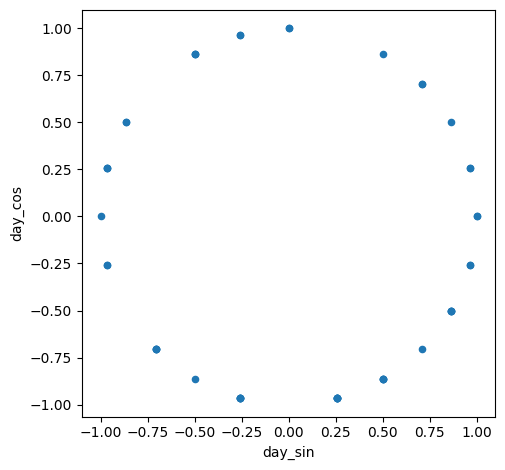

In [25]:
# Randomly sample 50 rows from the DataFrame and plot a scatter plot with 'day_sin' on the x-axis and 'day_cos' on the y-axis
# Set the aspect ratio of the plot to be equal, ensuring that the units are the same along both axes

df.sample(50).plot.scatter('day_sin','day_cos').set_aspect('equal');
plt.tight_layout()

*Plot of a sample of the day_sin and day_cos encoding. We have successfully
encoded the time as a numerical value while keeping the daily cycle.*

Here we’ll use a simple 70:20:10 split for the train, validation, and test sets. While
10% of the data seems like a small portion for the test set, remember that we have more than 17,000 records, meaning that we will evaluate the model on more than
1,000 data points, which is more than enough.

In [28]:
n = len(df)

# Split 70:20:10 (train:validation:test)
train_df = df[0:int(n*0.7)]                # First 70% goes to the train set
val_df = df[int(n*0.7):int(n*0.9)]         # Next 20% goes to the validation set
test_df = df[int(n*0.9):]                  # The remaining 10% goes to the test set

train_df.shape, val_df.shape, test_df.shape

((12285, 5), (3510, 5), (1756, 5))

In [29]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,12285.0,278.748005,12.505020,243.39,270.420000,2.788900e+02,288.890000,307.02
clouds_all,12285.0,43.103378,39.371566,0.00,1.000000,4.000000e+01,90.000000,100.00
traffic_volume,12285.0,3307.579406,1961.138844,113.00,1302.000000,3.504000e+03,4924.000000,7280.00
day_sin,12285.0,0.000065,0.707064,-1.00,-0.707107,-2.598120e-14,0.707107,1.00
day_cos,12285.0,-0.000083,0.707208,-1.00,-0.707107,-1.371531e-14,0.707107,1.00


In [30]:
from sklearn.preprocessing import MinMaxScaler  

scaler = MinMaxScaler()  # Scales features to a given range (default: 0 to 1)

scaler.fit(train_df)     # Fit the scaler to the training data, calculating the minimum and maximum values for each column

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])  # Apply the scaling transformation to the training data
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])          # Apply the same scaling transformation to the validation data
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])      # Apply the same scaling transformation to the test data

It is worth mentioning why the data is scaled and not normalized. Scaling and normalization can be confusing terms for data scientists, as they are often used interchangeably. In short, scaling the data affects only its scale and not its distribution. Thus, it simply forces the values into a certain range. In our case, we force the values to be between 0 and 1.

Normalizing the data, on the other hand, affects its distribution and its scale. Thus, normalizing the data would force it to have a normal distribution or a Gaussian distribution. The original range would also change, and plotting the frequency of each value would generate a classic bell curve.

Normalizing the data is only useful when the models we use require the data to be normal. For example, linear discriminant analysis (LDA) is derived from the assumption of a normal distribution, so it is better to normalize data before using LDA. However, in the case of deep learning, no assumptions are made, so normalizing is not required.

In [32]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,12285.0,0.555681,0.196527,0.0,0.424800,0.557913,0.715072,1.0
clouds_all,12285.0,0.431034,0.393716,0.0,0.010000,0.400000,0.900000,1.0
traffic_volume,12285.0,0.445735,0.273635,0.0,0.165899,0.473141,0.671271,1.0
day_sin,12285.0,0.500032,0.353532,0.0,0.146447,0.500000,0.853553,1.0
day_cos,12285.0,0.499959,0.353604,0.0,0.146447,0.500000,0.853553,1.0


In [33]:
# Let's save our data

train_df.to_csv('data/train.csv')
val_df.to_csv('data/val.csv')
test_df.to_csv('data/test.csv')

In [34]:
test_df

,temp,clouds_all,traffic_volume,day_sin,day_cos
15795,0.767405,0.90,0.401563,0.500000,1.000000
15796,0.756876,0.90,0.348821,0.629410,0.982963
15797,0.754833,0.90,0.302637,0.750000,0.933013
15798,0.754833,0.90,0.187108,0.853553,0.853553
15799,0.756247,0.90,0.080926,0.933013,0.750000
...,...,...,...,...,...
17546,0.629577,0.75,0.478582,0.370590,0.982963
17547,0.618733,0.90,0.372262,0.500000,1.000000
17548,0.618262,0.90,0.285475,0.629410,0.982963
17549,0.608204,0.90,0.186549,0.750000,0.933013
